In [1]:
import numpy as np
#from multiprocessing import Pool
from multiprocessing.pool import ThreadPool as Pool
from multiprocessing import active_children, Process, Queue
from functools import partial
from scipy import sparse
from sys import getsizeof
import matplotlib.pyplot as plt
import chess
import chess.svg

In [2]:
def getPosition(posId, n):
    pos = []
    while (n > 0):
        pos.append(posId % 65)
        posId = posId // 65
        n -= 1
    return pos[::-1]
getPosition(64**5, 5)

[60, 9, 55, 4, 64]

In [3]:
def getPosId(position):
    posId = 0
    for square in position:
        posId *= 65
        posId += square
    return posId
getPosId([60, 9, 55, 4, 64]) == 64**5

True

In [4]:
np.unique([60,9,55,4,55], return_counts=True)

(array([ 4,  9, 55, 60]), array([1, 1, 2, 1], dtype=int64))

In [5]:
def isValidPosId(posId, n):
    pos = set()
    whiteKingPos = -1
    blackKingPos = -1
    while (n > 0):
        square = posId % 65
        
        if n == 1:
            whiteKingPos = square
            if square == 64:
                return False
        elif n == 2:
            blackKingPos = square
            if square == 64:
                return False
        
        if square in pos and square != 64:
            return False
        
        pos.add(posId % 65)
        posId = posId // 65
        n -= 1
    
    if blackKingPos in getSight(whiteKingPos, "K"):
        return False
    
    return True
v_isValidPosId = np.vectorize(isValidPosId)

In [6]:
def getRowCol(square):
    return (square // 8, square % 8)

def getSquare(row, col):
    return row * 8 + col

getRowCol(59), getSquare(7, 3)

((7, 3), 59)

In [7]:
for i in range(64):
    if i % 8 == 0:
        print('\n')
    print(i, end="\t")



0	1	2	3	4	5	6	7	

8	9	10	11	12	13	14	15	

16	17	18	19	20	21	22	23	

24	25	26	27	28	29	30	31	

32	33	34	35	36	37	38	39	

40	41	42	43	44	45	46	47	

48	49	50	51	52	53	54	55	

56	57	58	59	60	61	62	63	

In [8]:
def getRawSight(square, position, distance = 1, orthogonal = True, diagonal = True, knight = False):
    row, col = getRowCol(square)
    seenSquares = []
    occupiedSquares = position
    
    if square == 64:
        return seenSquares

    # LR and UD are the left-right and up-down axes,
    #  and n represents how far in that direction
    for lr in range(-2, 3):
        for ud in range(-2, 3):
            for n in range(1, distance + 1):
                axis = abs(lr) + abs(ud)
                equality = abs(lr) == abs(ud);
                if ((diagonal and axis == 2 and equality) or 
                    (orthogonal and axis == 1) or
                    (knight and axis == 3)):
                    newRow = row + ud * n;
                    newCol = col + lr * n;
                    newSquare = newRow * 8 + newCol;
                    if (newRow < 0 or newRow > 7 or newCol < 0 or newCol > 7):
                        break
                    if newSquare in occupiedSquares:
                        seenSquares.append(newSquare)
                        break
                    else:
                        seenSquares.append(newSquare)
    return seenSquares

def getSightLine(fromSquare, toSquare):
    fRow, fCol = getRowCol(fromSquare)
    tRow, tCol = getRowCol(toSquare)
    ud = 0
    lr = 0
    
    orthogonal = fRow == tRow or fCol == tCol
    diagonal = fRow - tRow == fCol - tCol
    if not (orthogonal or diagonal):
        return [fromSquare]
    
    if fRow == tRow and fCol == tCol:
        return []
    if fRow != tRow:
        ud = (tRow - fRow) / abs(tRow - fRow)
    if fCol != tCol:
        lr = (tCol - fCol) / abs(tCol - fCol)
    
    squares = []
    for n in range(8):
        newRow = fRow + n * ud
        newCol = fCol + n * lr
        newSquare = getSquare(newRow, newCol)
        if newSquare == toSquare:
            break
        squares.append(int(newSquare))
    
    return squares
        

def getSight(square, piece, position=[]):
    match piece.upper():
        case "K":
            return getRawSight(square, position)
        case "Q":
            return getRawSight(square, position, distance=8)
        case "B":
            return getRawSight(square, position, distance=8, orthogonal=False)
        case "R":
            return getRawSight(square, position, distance=8, diagonal=False)
        case "N":
            return getRawSight(square, position, diagonal=False, orthogonal=False, knight=True)

In [9]:
# pieceConfig = "KkQqBbNnRrPp"
def isMate(posId, pieceConfig):
    n = len(pieceConfig)
    position = getPosition(posId, n)
    
    posSansBK = position[:]
    posSansBK[1] = 64
    
    whitePieces = []
    blackPieces = []
    
    for sqIndex, piece in enumerate(pieceConfig):
        if piece == piece.upper():
            whitePieces.append((sqIndex, piece))
        else:
            blackPieces.append((sqIndex, piece))
    
    sights = [getSight(position[i], pieceConfig[i], position) if pieceConfig[i] == pieceConfig[i].lower() else getSight(position[i], pieceConfig[i], posSansBK) for i in range(n)]
    #blackSight = np.unique([x for sqIndex, piece in enumerate(pieceConfig) if piece == piece.lower() for x in sights[sqIndex]])
    whiteSight = [x for sqIndex, piece in whitePieces for x in sights[sqIndex]]
    
    # Check if King can move anywhere
    for move in sights[1] + [position[1]]:
        if move not in whiteSight:
            return False
        
    if len(blackPieces) > 1:
        checkingPieces = [sqIndex for sqIndex, piece in whitePieces if position[1] in sights[sqIndex]]
        # Check if blockable
        if len(checkingPieces) == 1 and checkingPieces[0] != 'N':
            checkSight = getSightLine(position[checkingPieces[0]], position[1])
            for sqIndex, piece in blackPieces[1:]:
                for move in sights[sqIndex]:
                    if move in checkSight:
                        return False
        
    return True
v_isMate = np.vectorize(isMate)
#%timeit -r 3 -n 3 visMate(c[valid], "KkQ")
#%timeit -r 20 isMate(getPosId([62, 47, 30]), "KkQ")
isMate(getPosId([19, 2, 0]), "KkQ")

True

In [10]:
def isCheck(position, pieceConfig, sights, colorToMove="black"):
    colorCheck = lambda piece: piece == piece.lower() if colorToMove == "black" else piece == piece.upper()
    myKing = position[1] if colorToMove == "black" else position[0]
    opposingSight = [x for sqIndex, piece in enumerate(pieceConfig) if not colorCheck(piece) for x in sights[sqIndex]]
    return myKing in opposingSight

def whiteRegressions(posId, pieceConfig):
    n = len(pieceConfig)
    position = getPosition(posId, n)

    whitePieces = [(sqIndex, piece) for sqIndex, piece in enumerate(pieceConfig) if piece == piece.upper()]
    sights = [getSight(position[sqIndex], piece, position) if piece == piece.upper() else [] for sqIndex, piece in enumerate(pieceConfig)]
    checkingPieces = [sqIndex for sqIndex, piece in enumerate(pieceConfig) if piece == piece.upper() and position[1] in sights[sqIndex]]
    
    regressions = []
    for sqIndex, piece in enumerate(pieceConfig):
        # This is the sight of the piece if it were sitting on the black king's square
        kingPOV = getSight(position[1], piece, position[:sqIndex] + [position[1]] + position[sqIndex + 1:])
        if piece == piece.lower():
            continue
        for move in sights[sqIndex]:
            if move in kingPOV:
                continue
            newPos = position[:]
            if move in position:
                index = position.index(move)
                piece = pieceConfig[index]
                # capture piece
                if piece == piece.lower():
                    newPos[index] = 64
                # overlapping white pieces
                else:
                    continue
                
            if newPos[1] == 64:
                continue
                
            newPos[sqIndex] = move
                
            if len(checkingPieces) == 0:
                for otherSight in sights:
                    if position[sqIndex] in otherSight:
                        continue
            elif sqIndex not in checkingPieces:
                continue
            elif len(checkingPieces) > 1:
                newSights = sights[:]
                newSights[sqIndex] = getSight(move, piece, newPos)
                if isCheck(newPos, pieceConfig, newSights):
                    continue
            
            regressions.append(getPosId(newPos))
    return regressions

v_whiteRegressions = np.vectorize(whiteRegressions)

#%timeit -r 20 whiteRegressions(getPosId([61, 63, 7]), "KkQ")
whiteRegressions(getPosId([61, 63, 7]), "KkQ")

[261826,
 261825,
 261824,
 261823,
 261822,
 261821,
 261834,
 261841,
 261848,
 261855,
 261862,
 261869,
 261876]

Optimizations for above:
- I need to make sure that the regression for white doesn't result in a check. Brute force checking made it so that it would take >5ms per position to find all of the regressions that don't result in check
- Instead of checking if the new move will result in a check, I can use the sight from the black king's position to make sure the new move doesn't land on those squares (this is kingPOV)
- Also, if there is a piece that is currently checking the king, the only way to regress from there is to either move the checking piece, or move another piece such that it is "blocking" the check, this is what a discovered check would be if I wasn't doing all of this backwards
- If there are 2 pieces currently checking the king, I just manually make sure there is no check here, since this is a fairly rare occurance that does not need the heavy optimization
- If there are no pieces checking the king, any move that is not in the kingPOV will keep it that way, so we move as normal

All of these savings results in a running time of <1ms per position. That's over 5x faster.

In [11]:
def getMatedFromKing(posId, newPiece):
    position = getPosition(posId, 2)
    whiteKing = position[0]
    blackKing = position[1]
    baseId = getPosId([whiteKing, blackKing, 0])
    
    whiteSquares = set(getSight(whiteKing, 'k', []))
    blackSquares = set(getSight(blackKing, 'k', []) + [blackKing])
    moveableSquares = blackSquares.difference(whiteSquares)
    
    allMates = set()
    for index, square in enumerate(moveableSquares):
        newSight = set(getSight(square, newPiece, [whiteKing, 64]))
        if index == 0:
            allMates = newSight
        else:
            allMates = allMates.intersection(newSight)
    
    return set([baseId + square for square in allMates])
getMatedFromKing(21*65 + 23, 'Q')

# This can be optimized, its just a hack for now
def whiteInCheck(whiteKing, blackSights):
    for piece, pos, sights in blackSights:
        if whiteKing in sights:
            return True
    return False

def getMatedNewPiece(posId, pieceConfig, newPiece):
    position = getPosition(posId, len(pieceConfig))
    whiteKing = position[0]
    blackKing = position[1]
    baseId = getPosId(position + [0])
    
    whiteSights = [(piece, position[sqIndex], getSight(position[sqIndex], piece, position)) for sqIndex, piece in enumerate(pieceConfig) if piece == piece.upper()]
    whiteSquares = set([square for piece, square, sight in whiteSights for square in sight])
    checkingPieces = [(piece, square, sight) for piece, square, sight in whiteSights if blackKing in sight]
    
    blackSights = [(piece, position[sqIndex], getSight(position[sqIndex], piece, position)) for sqIndex, piece in enumerate(pieceConfig) if piece == piece.lower()]
    blackSquares = set(getSight(blackKing, 'k', []) + [blackKing])
    interseptions = set([square for sqIndex, piece in enumerate(pieceConfig[2:], start=2) if piece == piece.lower() for square in getSight(position[sqIndex], piece, position)])
    
    moveableSquares = blackSquares.difference(whiteSquares)
    
    allMates = set()
    for index, square in enumerate(moveableSquares):
        newSight = set(getSight(square, newPiece, [whiteKing, 64] + position[2:]))
        if index == 0:
            allMates = newSight
        else:
            allMates = allMates.intersection(newSight)
            
    if blackKing not in whiteSquares:
        for move in list(allMates):
            sightLine = set(getSightLine(move, blackKing))
            if len(sightLine.intersection(interseptions)) > 0:
                allMates.discard(move)
    elif (len(checkingPieces) == 1 and
          len(set(getSightLine(checkingPieces[0][1], blackKing)).intersection(interseptions)) >= 1):
        checkSquares = set(getSight(blackKing, newPiece, [whiteKing, 64] + position[2:]))
        allMates = allMates.intersection(checkSquares)
    
    # make sure white is not in check (this can be optimized)
    for posId in allMates.copy():
        if whiteInCheck(position[0], blackSights):
            allMates.remove(posId)
    
    # make sure position is not covered
    for posId in position:
        if posId in allMates:
            allMates.remove(posId)
    
    return set([baseId + square for square in allMates])

getMatedNewPiece(getPosId([29, 31, 6, 13]), 'KkrB', 'Q')

{526207702, 526207710, 526207725, 526207742, 526207750, 526207758}

In [31]:
def getRegressions(posId, pieceConfig, colorToMove="white"):
    n = len(pieceConfig)
    position = getPosition(posId, n)

    # colorCheck(piece) returns true if piece is of the color to move
    colorCheck = lambda piece: piece == piece.upper() if colorToMove == "white" else piece == piece.lower()
    kingdex = 0 if colorToMove == "white" else 1
    myKing = position[kingdex]
    opposingKing = position[1 - kingdex]
    
    movingPieces = [(sqIndex, piece) for sqIndex, piece in enumerate(pieceConfig) if colorCheck(piece)]
    sights = [getSight(position[sqIndex], piece, position) if colorCheck(piece) else [] for sqIndex, piece in enumerate(pieceConfig)]
    opposingSightsMinusMyKing = [x if not colorCheck(piece) else [] for sqIndex, piece in enumerate(pieceConfig) for x in getSight(position[sqIndex], piece, position[:kingdex] + position[kingdex + 1:])]
    checkingPieces = [sqIndex for sqIndex, piece in enumerate(pieceConfig) if colorCheck(piece) and opposingKing in sights[sqIndex]]
    
    capturedPieces = [(sqIndex, piece) for sqIndex, piece in enumerate(pieceConfig) if not colorCheck(piece) and position[sqIndex] == 64]
    
    regressions = []
    
    if myKing in opposingSightsMinusMyKing:
        return regressions
    
    for sqIndex, piece in enumerate(pieceConfig):
        if not colorCheck(piece):
            sight = getSight(position[sqIndex], piece, position[:kingdex] + position[kingdex + 1:])
            # if my king is currently in check by this piece (invalid position to regress from)
            if myKing in sight:
                return []
            continue
        
        # This is the sight of the piece if it were sitting on the opposing king's square
        kingPOV = getSight(opposingKing, piece, position[:sqIndex] + [opposingKing] + position[sqIndex + 1:])
        
        for move in sights[sqIndex]:
            # if the backwards move would be check (illegal)
            if move in kingPOV:
                continue
            newPos = position[:]
            
            # if move came from another piece location (illegal)
            if move in position:
                continue
                
            # make the move
            oldPos = newPos[sqIndex]
            newPos[sqIndex] = move
            
            if len(checkingPieces) == 0:
                for otherSight in sights:
                    if position[sqIndex] in otherSight:
                        continue
            elif sqIndex not in checkingPieces:
                continue
            elif len(checkingPieces) > 1:
                newSights = sights[:]
                newSights[sqIndex] = getSight(move, piece, newPos)
                if isCheck(newPos, pieceConfig, newSights, colorToMove):
                    continue
            
            # TODO: review logic for captures
            regressions.append(getPosId(newPos))
            for index, capturedPiece in capturedPieces:
                tempPos = newPos[:]
                tempPos[index] = oldPos
                regressions.append(getPosId(tempPos))
            
    return regressions

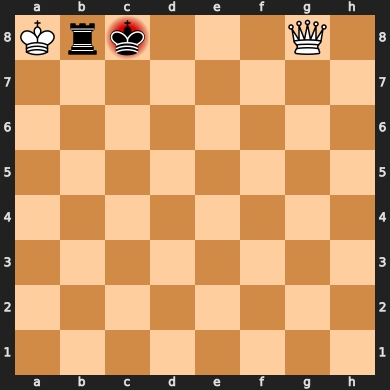

In [13]:
def getBoard(posId, pieceConfig, colorToMove="black"):
    position = getPosition(posId, len(pieceConfig))
    board = np.array([""] * 64)
    for sqIndex, piece in enumerate(pieceConfig):
        pieceLocation = position[sqIndex]
        if pieceLocation == 64:
            continue
        board[pieceLocation] = piece
    
    fen = ''
    for rowNum, row in enumerate(board.reshape((8,8))):
        emptyCount = 0
        if rowNum > 0:
            fen += '/'
        for colNum, square in enumerate(row):
            if square == '':
                emptyCount += 1
            elif emptyCount > 0:
                fen += str(emptyCount)
                fen += square
                emptyCount = 0
            else:
                fen += square
            
            if colNum == 7 and emptyCount != 0:
                fen += str(emptyCount)
    
    return chess.Board(fen + ' ' + colorToMove[0].lower())

def getBoard2(posId):
    colorToMove = "black" if posId < (WIDTH // 2) else "white"
    return getBoard(posId % (WIDTH // 2), pieceConfig, colorToMove)
    
display(getBoard(8521, 'KkrQ'))

In [14]:
def rotateSquare(square):
    if square == 64:
        return square
    return ((square << 3) & 63) + 7 - (square >> 3)

def flipSquare(square):
    if square == 64:
        return square
    return square - (square & 7) + 7 - (square & 7)

def getAdjBoards(posId, n):
    position = getPosition(posId, n)
    newPosIds = np.zeros(7, dtype="int")
    for square in position:
        newSquare = np.array([square] * 7)
        for i in range(7):
            if i % 2 == 0:
                newSquare[i] = flipSquare(newSquare[i])
            for j in range((i + 1) // 2):
                newSquare[i] = rotateSquare(newSquare[i])
        newPosIds *= 65
        newPosIds += newSquare
        
    return np.unique(newPosIds[newPosIds != posId])

pos = 76059
newPos = getAdjBoards(pos, 3)
display(newPos)

array([ 89194, 181139, 194274])

### Generate graph of positions

In [15]:
%%time
pieceConfig = 'KkQ'
num_pieces = len(pieceConfig)
WIDTH = 2 * 65**num_pieces
# G = sparse.csc_matrix((WIDTH, WIDTH), dtype="uint8")
G = sparse.lil_matrix((WIDTH, WIDTH), dtype="uint8")

whiteChecked, blackChecked = set(), set()
whiteToCheck, blackToCheck = set(), set()

mated_pos = sparse.lil_matrix((1, 65**num_pieces))
for posId in range(65**(num_pieces - 1)):
    if posId not in blackToCheck and isValidPosId(posId, num_pieces - 1):
        for mate in getMatedNewPiece(posId, pieceConfig[:-1], pieceConfig[-1]):
            mated_pos[0, mate] = 1
            blackToCheck.add(mate)
            for adj in getAdjBoards(mate, num_pieces):
                mated_pos[0, adj] = 1
                blackToCheck.add(adj)

n = 1
while len(blackToCheck) > 0 or len(whiteToCheck) > 0:
    print('⬛Black progress:', len(blackToCheck), len(blackChecked), '{:.1%}'.format(len(blackChecked) / 65**num_pieces))
    print('⬜White progress:', len(whiteToCheck), len(whiteChecked), '{:.1%}'.format(len(whiteChecked) / 65**num_pieces))
    #print('G density:', '{:.1%}'.format(G.count_nonzero() / (2 * 65**num_pieces)**2))
    
#     ADD = sparse.lil_matrix((WIDTH, WIDTH), dtype="uint8")
    
    blackToCheck.difference_update(blackChecked)
    for posId in blackToCheck:
        # adjPositions = getAdjBoards(posId, num_pieces)
        regressions = getRegressions(posId, pieceConfig, "white")
        for reg in regressions:
#             ADD[posId, reg + 65**num_pieces] = n
            G[posId, reg + 65**num_pieces] = n
            whiteToCheck.add(reg)
        blackChecked.add(posId)
    
    whiteToCheck.difference_update(whiteChecked)
    for posId in whiteToCheck:
        # adjPositions = getAdjBoards(posId, num_pieces)
        regressions = getRegressions(posId, pieceConfig, "black")
        for reg in regressions:
#             ADD[posId + 65**num_pieces, reg] = n
            G[posId + 65**num_pieces, reg] = n
            blackToCheck.add(reg)
        whiteChecked.add(posId)
#     G += ADD
    n += 1

G = G.tocsc()
print(len(blackChecked), len(whiteChecked))

display(G, mated_pos)

⬛Black progress: 364 0 0.0%
⬜White progress: 0 0 0.0%


C:\Users\Jagvi\AppData\Local\Temp\ipykernel_16664\3958069037.py:21: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if position[kingdex] in opposingSightsMinusMyKing:


⬛Black progress: 5004 364 0.1%
⬜White progress: 2448 2448 0.9%
⬛Black progress: 39020 5004 1.8%
⬜White progress: 13924 16372 6.0%
⬛Black progress: 124200 39384 14.3%
⬜White progress: 49256 65628 23.9%
⬛Black progress: 168608 128380 46.7%
⬜White progress: 59632 125260 45.6%
⬛Black progress: 96496 202296 73.7%
⬜White progress: 21280 146540 53.4%
⬛Black progress: 20212 218408 79.5%
⬜White progress: 2872 149412 54.4%
⬛Black progress: 2260 220628 80.3%
⬜White progress: 16 149428 54.4%
⬛Black progress: 24 220652 80.3%
⬜White progress: 0 149428 54.4%
220652 149428


<549250x549250 sparse matrix of type '<class 'numpy.uint8'>'
	with 4823312 stored elements in Compressed Sparse Column format>

<1x274625 sparse matrix of type '<class 'numpy.float64'>'
	with 364 stored elements in List of Lists format>

CPU times: total: 4min 6s
Wall time: 8min 12s


In [16]:
# old: 1m37s, 5m1s
# new: 1m19s, 4m46s

In [17]:
v = np.zeros(WIDTH)
v[283085] = 1
R1 = G.dot(v)
display(R1.nonzero())
M1 = sparse.dia_array((R1, [0]), (WIDTH, WIDTH))
display(M1.nonzero())
R2 = G.dot(M1)
display(R2.nonzero()[1])
F = np.setdiff1d(R1.nonzero()[0], R2.nonzero()[1])
display(F)

(array([8451, 8453, 8459, 8468, 8469, 8474, 8478, 8484, 8487, 8492, 8496,
        8500, 8505, 8508], dtype=int64),)

(array([8451, 8453, 8459, 8468, 8469, 8474, 8478, 8484, 8487, 8492, 8496,
        8500, 8505, 8508]),
 array([8451, 8453, 8459, 8468, 8469, 8474, 8478, 8484, 8487, 8492, 8496,
        8500, 8505, 8508]))

array([8453, 8468, 8469, 8478, 8484, 8487, 8492, 8496, 8500, 8505, 8508],
      dtype=int32)

array([8451, 8459, 8474], dtype=int64)

In [18]:
## CURRENTLY ONLY SUPPORTS KING MOVEMENT
def getProgressions(posId, pieceConfig, colorToMove="black"):
    n = len(pieceConfig)
    position = getPosition(posId, n)

    # colorCheck(piece) returns true if piece is of the color to move
    colorCheck = lambda piece: piece == piece.upper() if colorToMove == "white" else piece == piece.lower()
    kingdex = 0 if colorToMove == "white" else 1
    myKing = position[kingdex]
    
    movingPieces = [(sqIndex, piece) for sqIndex, piece in enumerate(pieceConfig) if colorCheck(piece)]
    
    # Get sights WITHOUT king
    sights = [getSight(position[sqIndex], piece, position[0:kingdex] + position[kingdex + 1:]) for sqIndex, piece in enumerate(pieceConfig)]
    mySights = [pos for sqIndex, piece in enumerate(pieceConfig) if colorCheck(piece) for pos in sights[sqIndex]]
    theirSights = [pos for sqIndex, piece in enumerate(pieceConfig) if not colorCheck(piece) for pos in sights[sqIndex]]
    myKingSights = sights[kingdex]
    
    checkingPieces = [sqIndex for sqIndex, piece in enumerate(pieceConfig) if not colorCheck(piece) and myKing in sights[sqIndex]]
    
    progressions = set()
    if len(checkingPieces) == 0:
        pass
    elif len(checkingPieces) == 1:
        checkingPiece = checkingPieces[0]
        sightLine = getSightLine(position[checkingPiece], myKing)
        isDefended = position[checkingPiece] in theirSights
        
        # Can king take checking piece?
        if position[checkingPiece] in myKingSights and not isDefended:
            newPos = position[:]
            newPos[kingdex] = newPos[checkingPiece]
            newPos[checkingPiece] = 64
            progressions.add(getPosId(newPos))
        
        # TODO: Can check be blocked by another piece?
        ## Watch out for pinned pieces
        
    # Add all legal king moves
    for kingMove in myKingSights:
        if kingMove not in theirSights and kingMove not in position:
            newPos = position[:]
            newPos[kingdex] = kingMove
            progressions.add(getPosId(newPos))
    
    return progressions
    
testpos = 254953
#display(testpos, getBoard2(testpos))
test = getProgressions(testpos, 'KkQ')
for t in test:
    #display(t, getBoard2(t))
    pass
test

{254368, 255059, 255408}

254953

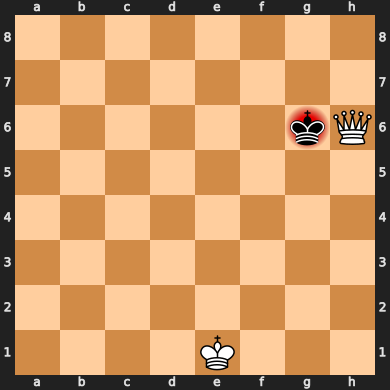

DRAW 254953


528993

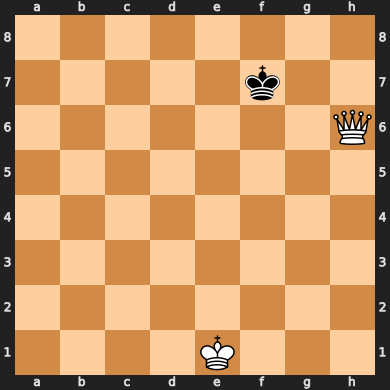

530033

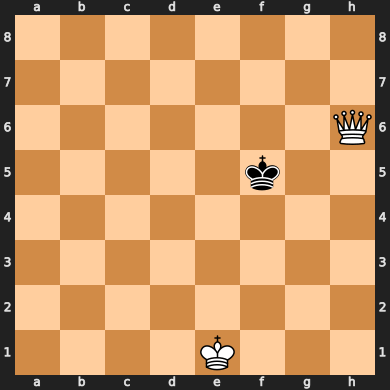

In [19]:
def getVector(posIds):
    v = np.zeros(WIDTH)
    for posId in posIds:
        v[posId] = 1
    return v

def getDiagonal(vector):
    return sparse.dia_array((vector, [0]), shape=(WIDTH,WIDTH))

start = getPosId([60,22,23])
display(start, getBoard2(start))
graphProgressions = G.dot(getVector([start])).nonzero()[0]
progressions = getProgressions(start, pieceConfig, "black")
if len(graphProgressions) < len(progressions):
    print("DRAW", start)
for r in graphProgressions:
    display(r, getBoard2(r))

### Get all the draws

In [20]:
%%time
# for i in range(65**num_pieces):
#     getVector([i])
R = G.dot(getDiagonal(getVector(range(WIDTH//2))))
colnnz = R.getnnz(axis=0)
draws = set()
for col in range(WIDTH//2):
    if not isValidPosId(col, len(pieceConfig)):
        continue
    colsum = colnnz[col]
    progressions = getProgressions(col, pieceConfig)
    if len(progressions) > colsum:
        draws.add(col)
    
    # Percentage indicator
    if col % (WIDTH//200) == 0:
        print(col, str((col * 100) // (WIDTH//2)) + "%", end="\r")
len(draws)

CPU times: total: 47 s
Wall time: 1min 38s


25788

### Create new graph H, without all of the draws

In [21]:
%%time
H = G.copy().tolil()
for i in draws:
    H.rows[i], H.data[i] = list(), list()
H = H.tocsc()
display(H, G)

<549250x549250 sparse matrix of type '<class 'numpy.uint8'>'
	with 4578880 stored elements in Compressed Sparse Column format>

<549250x549250 sparse matrix of type '<class 'numpy.uint8'>'
	with 4823312 stored elements in Compressed Sparse Column format>

CPU times: total: 1.98 s
Wall time: 4.49 s


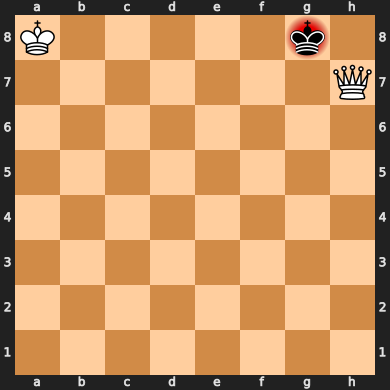

In [22]:
getBoard2(405)

### Create an array that holds all of the DTM (depth to mate) values for each position

In [23]:
%%time
def getMinCols(G):
    newarr = np.zeros(G.shape[0])
    for i in range(G.shape[0]):
        start = G.indptr[i]
        stop = G.indptr[i+1]
        if stop - start != 0:
            sl = slice(start, stop)
            if i >= G.shape[0] // 2:
                newarr[i] = np.min(G.data[sl])
            else:
                newarr[i] = np.max(G.data[sl])
        if i % 500 == 0:
            print(str(i * 100 // G.shape[0]) + "%", end="\r")
    return newarr

mincols = getMinCols(G)
mincols

CPU times: total: 1.19 s
Wall time: 7.03 s


array([0., 0., 0., ..., 0., 0., 0.])

152 	 3.0	https://lichess.org/analysis/K1k5/8/6Q1/8/8/8/8/8_b_-_-_0_1


152

3.0

(array([274842, 275297, 275362]), array([0, 0, 0]))

array([3, 3, 3], dtype=uint8)

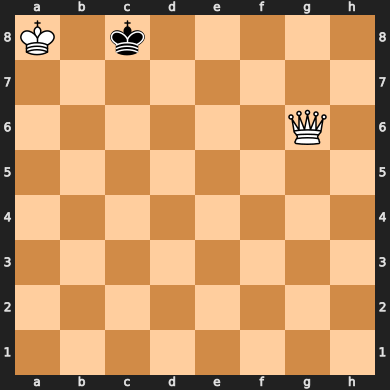

275362

3.0

(array([  721,   728,   729,   730,   731,   732,   736,   738,   744,
          745,   746,   751,   753,   758,   761,   765,   769,   772,
          777,  4962, 34537, 38762]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

array([5, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 3, 3],
      dtype=uint8)

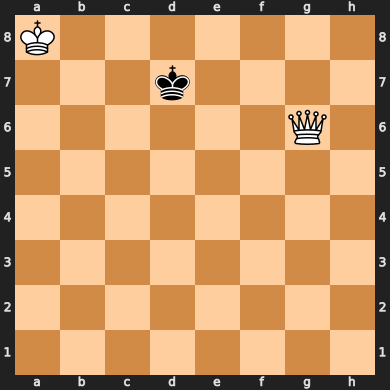

38762

3.0

(array([312867, 313452]), array([0, 0]))

array([2, 3], dtype=uint8)

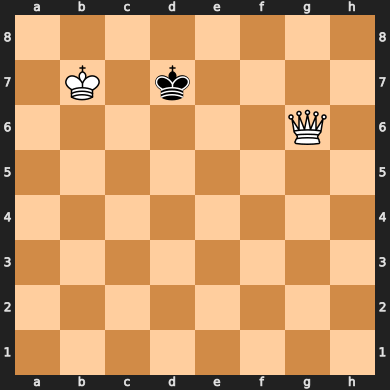

313452

3.0

(array([  802,  5027,  9252, 34602, 38811, 38819, 38820, 38821, 38822,
        38823, 38828, 38834, 38835, 38836, 38841, 38843, 38848, 38851,
        38855, 38859, 38862, 38867, 43052, 68402, 72627, 76852]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]))

array([4, 4, 5, 3, 4, 3, 3, 4, 4, 4, 3, 3, 4, 3, 3, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 3, 3], dtype=uint8)

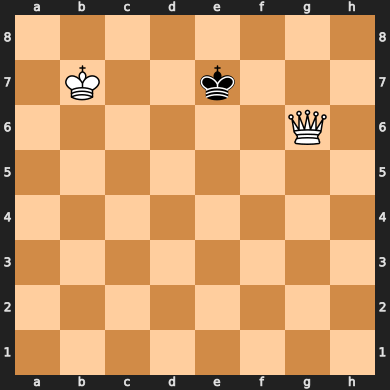

76852

3.0

(array([350892, 351022]), array([0, 0]))

array([2, 3], dtype=uint8)

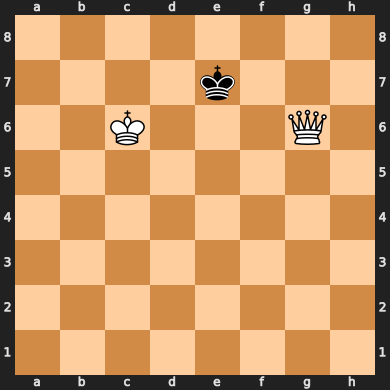

351022

3.0

(array([ 38372,  42597,  72172,  76390,  76394,  76395,  76396,  76398,
         76404,  76405,  76406,  76411,  76413,  76418,  76421,  76425,
         76429,  76432,  76437, 105972, 110197, 114422]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

array([4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4],
      dtype=uint8)

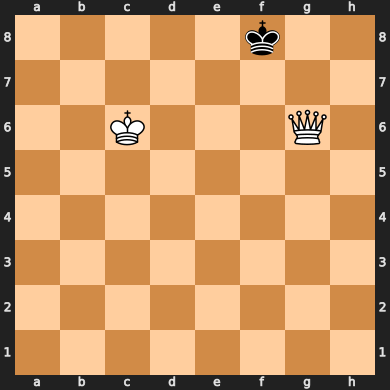

76390

2.0

(array([350950]), array([0]))

array([2], dtype=uint8)

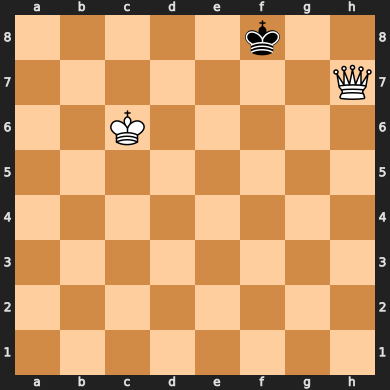

350950

2.0

(array([ 38300,  42525,  72100,  76316,  76317,  76318,  76319,  76320,
         76321,  76324,  76332,  76333,  76339,  76341,  76346,  76349,
         76353,  76357,  76360,  76365,  76367,  76373,  80550, 105900,
        110125, 114350]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]))

array([3, 3, 3, 3, 3, 2, 2, 3, 4, 2, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3,
       2, 3, 3, 3], dtype=uint8)

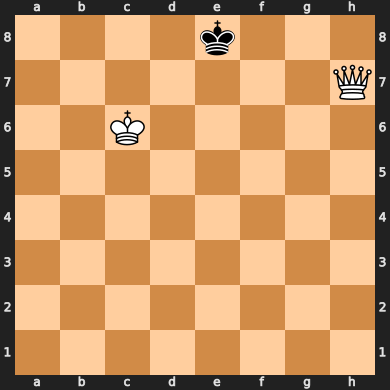

76324

1.0

(array([350884]), array([0]))

array([1], dtype=uint8)

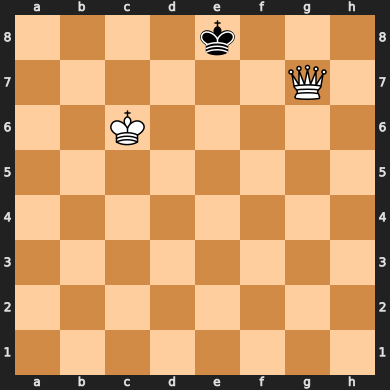

350884

1.0

(array([ 38234,  72034,  76250,  76251,  76252,  76253,  76254,  76255,
         76256,  76258,  76260,  76266,  76267,  76268,  76273,  76275,
         76280,  76283,  76287,  76291,  76294,  76299,  76301,  76307,
         80484, 105834, 110059, 114284]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]))

array([3, 2, 1, 3, 3, 2, 3, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3], dtype=uint8)

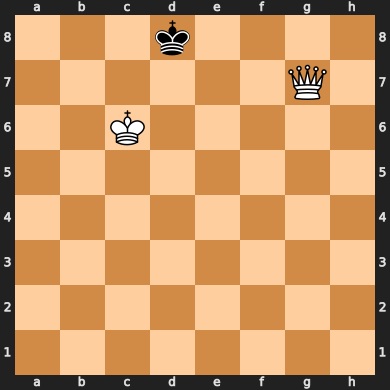

76256

0.0

(array([], dtype=int32), array([], dtype=int32))

array([], dtype=uint8)

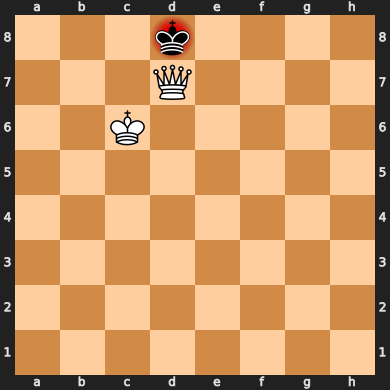

313452

3.0

(array([  802,  5027,  9252, 34602, 38811, 38819, 38820, 38821, 38822,
        38823, 38828, 38834, 38835, 38836, 38841, 38843, 38848, 38851,
        38855, 38859, 38862, 38867, 43052, 68402, 72627, 76852]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]))

array([4, 4, 5, 3, 4, 3, 3, 4, 4, 4, 3, 3, 4, 3, 3, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 3, 3], dtype=uint8)

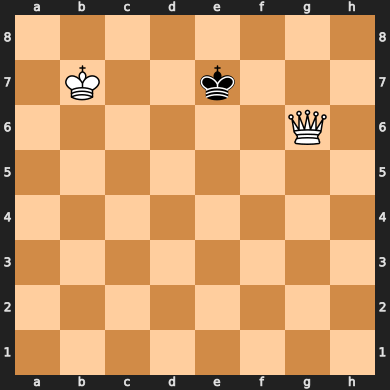

34602

4.0

(array([308642, 308772, 309162]), array([0, 0, 0]))

array([2, 4, 2], dtype=uint8)

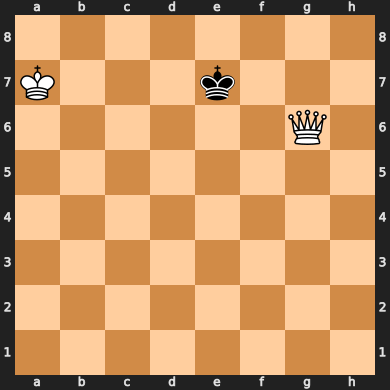

In [24]:
# display(mincols[131])

def getLichess(posId):
    URL = "https://lichess.org/analysis/"
    print((URL + getBoard2(posId).fen()).replace(" ", "_"))

for i in mincols.nonzero()[0][15:]:
    print(i, "\t", mincols[i], end="\t")
    getLichess(i)
    break

get = lambda posId: display(posId, mincols[posId], H[:, posId].nonzero(), H[:, posId].data, getBoard2(posId))
get(152) # 5 wrong
get(275362) # 5 wrong
get(38762) # 4 wrong
get(313452) # 4 wrong
get(76852) # 3
get(351022) # 3
get(76390) # 2
get(350950) # 2
get(76324) # 1
get(350884) # 1
get(76256) # 0

get(313452)
get(34602)
#get(312867)
#display(G[:, 275362].nonzero(), getBoard2(275362))

In [25]:
#H.data[34602] = [4 for x in H.data[34602]]
H[34602].data
H[34602, :].nonzero()[1]

array([275427, 279652, 309211, 309221, 309222, 309223, 309228, 309234,
       309236, 309243, 309248, 309251, 309255, 309259, 309262, 309267,
       313452, 343027, 347252])

### Fix all of the DTMs that were messily generated during the graph generation phase

In [32]:
%%time
def getNewVal(graph, posId):
    col = graph.data[posId]
    if len(col) == 0:
        return 0
    if posId >= graph.shape[0] // 2:
        return np.min(graph.data[posId]) + 1
    else:
        return np.max(graph.data[posId])

toChange = range(G.shape[0])
nextToChange = set()
hasChanged = set([-1])
iteration = 0
H = H.tolil()

while len(hasChanged) > 0:
    iteration += 1
    hasChanged.clear()
    nextToChange.clear()
    HT = H.transpose()
    for index, posId in enumerate(toChange):
        newVal = getNewVal(HT, posId)
        if mincols[posId] != newVal or (len(H.data[posId]) > 0 and H.data[posId][0] != newVal):
            mincols[posId] = newVal
            H.data[posId] = [newVal] * len(H.data[posId])
            nextToChange.update(H[posId, :].nonzero()[1])
            hasChanged.add(posId)
            if posId in nextToChange:
                nextToChange.remove(posId)
        if index % (len(toChange) // 200) == 0:
            print(len(toChange), '-', str((index * 100) // len(toChange)) + "%", end='                  \r')
    print("Changed", len(hasChanged), "of", len(toChange))
    toChange = nextToChange.copy()

H = H.tocsc()
print("Took", iteration, "iterations to complete.")
# i = 280886
# # while fixRow(i, mincols) is None:
# #     i += 1
# i, fixRow(i, mincols)

Changed 0 of 549250           
Took 1 iterations to complete.
CPU times: total: 2.81 s
Wall time: 7.78 s


In [27]:
mincols[76390], mincols[61180]

(2.0, 5.0)

In [28]:
choices = np.random.choice(range(2 * 65**3), size=10)
for choice in choices:
    display(choice, mincols[choice])
    getLichess(choice)

500382

0.0

https://lichess.org/analysis/8/4Q3/8/4k3/8/8/5K2/8_w_-_-_0_1


53319

6.0

https://lichess.org/analysis/8/4K3/3Q4/8/8/k7/8/8_b_-_-_0_1


492397

5.0

https://lichess.org/analysis/8/8/6Q1/8/3k4/8/3K4/8_w_-_-_0_1


481624

0.0

https://lichess.org/analysis/8/8/8/8/7Q/8/K7/8_w_-_-_0_1


155841

0.0

https://lichess.org/analysis/8/8/8/8/4Q3/8/8/1k6_b_-_-_0_1


517954

0.0

https://lichess.org/analysis/8/8/8/8/2Q3k1/8/8/1K6_w_-_-_0_1


454513

7.0

https://lichess.org/analysis/8/8/8/8/1Q3k2/2K5/8/8_w_-_-_0_1


394417

0.0

https://lichess.org/analysis/8/8/6k1/4K3/8/8/8/6Q1_w_-_-_0_1


33485

9.0

https://lichess.org/analysis/7K/2Q5/8/8/8/8/8/4k3_b_-_-_0_1


19966

8.0

https://lichess.org/analysis/4K3/3Q4/8/8/8/7k/8/8_b_-_-_0_1


In [29]:
H[158903].data, H[:, 433537].data, H[:, 433537].nonzero(), H[158903,433537], len(H.getcol(433537).data), H[:, 433537].indices[11]
#H[158903,433537]

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1], dtype=uint8),
 array([3, 3, 4, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 0, 1,
        2, 2, 6, 4], dtype=uint8),
 (array([120887, 125112, 154687, 158864, 158872, 158876, 158880, 158885,
         158888, 158894, 158896, 158903, 158904, 158908, 158909, 158910,
         158911, 158913, 158914, 158919, 158920, 158921, 188487, 192712]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0])),
 1,
 26,
 158898)

61180

5.0

(array([335740, 336260]), array([0, 0]))

array([3, 5], dtype=uint8)

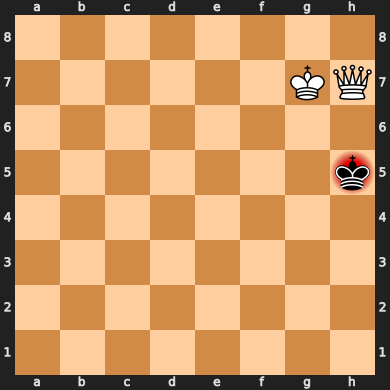

https://lichess.org/analysis/8/6KQ/8/7k/8/8/8/8_b_-_-_0_1
2


336260

5.0

(array([23610, 27835, 32060, 57410, 61626, 61627, 61642, 61643, 61656,
        61663, 61670, 61675, 61677, 61683, 91210, 95435, 99660]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

array([8, 8, 8, 7, 7, 7, 7, 7, 6, 4, 6, 6, 7, 7, 6, 7, 7], dtype=uint8)

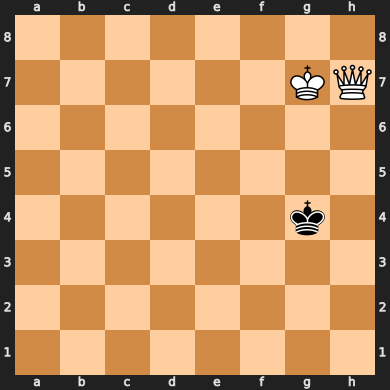

https://lichess.org/analysis/8/6KQ/8/8/6k1/8/8/8_w_-_-_0_1
17


61663

4.0

(array([335768, 335833, 336223, 336353]), array([0, 0, 0, 0]))

array([3, 4, 4, 4], dtype=uint8)

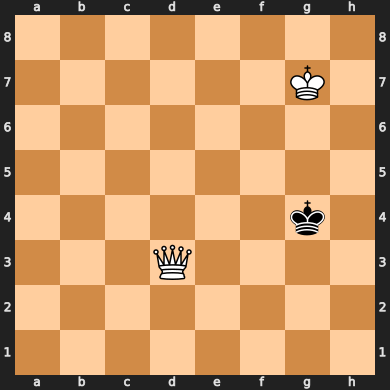

https://lichess.org/analysis/8/6K1/8/8/6k1/3Q4/8/8_b_-_-_0_1
4


335833

4.0

(array([23183, 27408, 31633, 56983, 61168, 61176, 61180, 61181, 61184,
        61187, 61190, 61192, 61194, 61199, 61200, 61201, 61205, 61206,
        61207, 61209, 61210, 61212, 61215, 61216, 61217, 61222, 61224,
        61226, 65433, 90783]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]))

array([5, 5, 6, 5, 5, 6, 5, 5, 5, 4, 6, 5, 4, 3, 3, 3, 5, 5, 5, 4, 4, 5,
       5, 5, 4, 5, 5, 5, 5, 3], dtype=uint8)

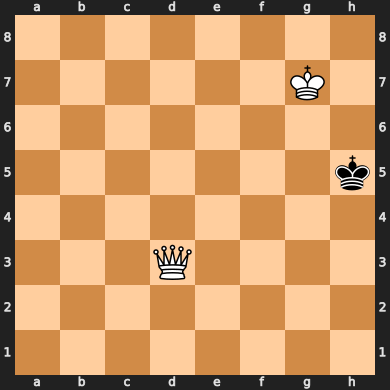

https://lichess.org/analysis/8/6K1/8/7k/8/3Q4/8/8_w_-_-_0_1
30


61199

3.0

(array([335759]), array([0]))

array([3], dtype=uint8)

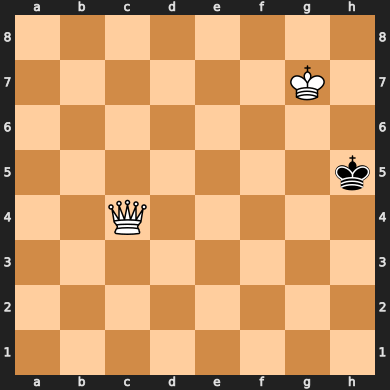

https://lichess.org/analysis/8/6K1/8/7k/2Q5/8/8/8_b_-_-_0_1
1


335759

3.0

(array([23109, 27334, 31559, 56909, 61102, 61106, 61110, 61113, 61116,
        61118, 61120, 61125, 61126, 61127, 61132, 61133, 61135, 61136,
        61141, 61142, 61143, 61148, 61150, 61152, 61158, 61161, 65359]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]))

array([6, 6, 6, 4, 7, 7, 7, 6, 6, 7, 6, 6, 7, 6, 5, 5, 4, 2, 6, 6, 5, 6,
       6, 4, 5, 5, 6], dtype=uint8)

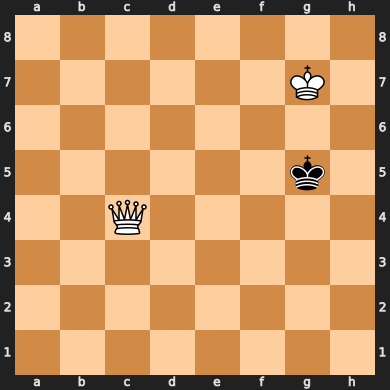

https://lichess.org/analysis/8/6K1/8/6k1/2Q5/8/8/8_w_-_-_0_1
27


61136

2.0

(array([335826]), array([0]))

array([2], dtype=uint8)

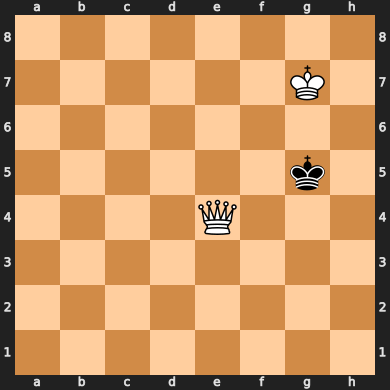

https://lichess.org/analysis/8/6K1/8/6k1/4Q3/8/8/8_b_-_-_0_1
1


335826

2.0

(array([23176, 27401, 31626, 56976, 61165, 61169, 61174, 61177, 61180,
        61183, 61185, 61187, 61192, 61193, 61194, 61197, 61198, 61199,
        61200, 61208, 61209, 61210, 61215, 61217, 61219, 61222, 61225,
        61228, 65426, 90776]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]))

array([3, 4, 4, 3, 7, 5, 7, 5, 5, 7, 5, 4, 5, 5, 4, 3, 3, 3, 3, 5, 4, 4,
       5, 4, 2, 5, 5, 6, 3, 1], dtype=uint8)

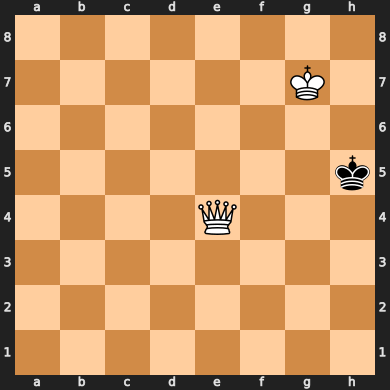

https://lichess.org/analysis/8/6K1/8/7k/4Q3/8/8/8_w_-_-_0_1
30


90776

1.0

(array([364881]), array([0]))

array([1], dtype=uint8)

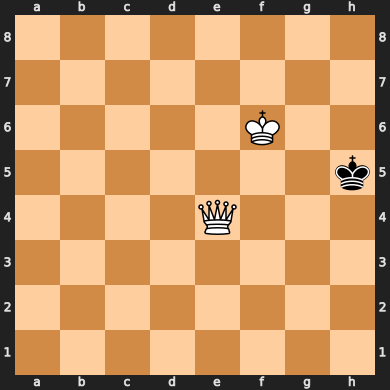

https://lichess.org/analysis/8/8/5K2/7k/4Q3/8/8/8_b_-_-_0_1
1


364881

1.0

(array([ 52231,  56456,  86031,  90220,  90224,  90229,  90232,  90238,
         90240,  90247,  90248,  90252,  90253,  90254,  90255,  90257,
         90258,  90263,  90264,  90265,  90270,  90272,  90274,  90277,
         90280, 119831, 124056]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]))

array([3, 3, 3, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2,
       2, 2, 1, 2, 2, 0, 4, 3], dtype=uint8)

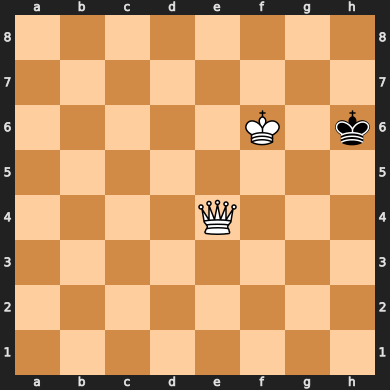

https://lichess.org/analysis/8/8/5K1k/8/4Q3/8/8/8_w_-_-_0_1
30


90242

0.0

(array([], dtype=int32), array([], dtype=int32))

array([], dtype=uint8)

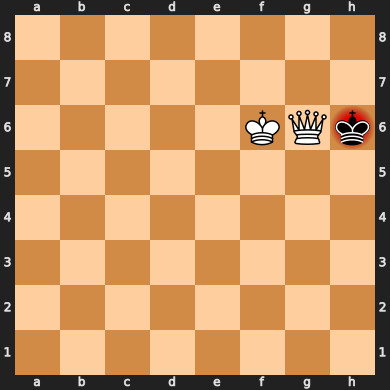

https://lichess.org/analysis/8/8/5KQk/8/8/8/8/8_b_-_-_0_1
0


In [30]:
def solve(posId, depth):
    # In case of infinite recursion
    if depth == 25:
        return
    get(posId)
    getLichess(posId)
    arg = 0
    print(len(H[:, posId].data))
    if len(H[:, posId].data) == 0:
        return
    if posId < WIDTH//2:
        arg = np.argmax(H[:, posId].data)
    else:
        arg = np.argmin(H[:, posId].data)
#     print(posId, arg, H[:, posId].data, H[:, posId].nonzero()[0])
    solve(H[:, posId].indices[arg], depth + 1)
    
solve(61180, 1)

In [37]:
# sparse.save_npz("KkQ.npz", H, compressed=True)
test = sparse.load_npz("KkQ.npz")
test, G, H

(<549250x549250 sparse matrix of type '<class 'numpy.uint8'>'
 	with 4578880 stored elements in Compressed Sparse Column format>,
 <549250x549250 sparse matrix of type '<class 'numpy.uint8'>'
 	with 4823312 stored elements in Compressed Sparse Column format>,
 <549250x549250 sparse matrix of type '<class 'numpy.uint8'>'
 	with 4578880 stored elements in Compressed Sparse Column format>)